In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
import json
import requests

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
df = pd.read_csv("static/BTC-USD_1d.csv")
del df["Adj Close"]
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df['month'] = df['Date'].apply(lambda data: data.month)
df['dayofweek'] = df['Date'].apply(lambda data: data.dayofweek)

In [9]:
sorted(df['dayofweek'].unique())

[0, 1, 2, 3, 4, 5, 6]

[0, 1, 2, 3, 4, 5, 6]: 0 -> Mon, 6 -> Sun

In [10]:
sorted(df['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 1 -> Jan, 12 -> Dec

In [11]:
dow = pd.DataFrame(to_categorical(df["dayofweek"], 7))
dow.columns = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]

In [12]:
m = pd.DataFrame(to_categorical(df["month"]))
m = m.drop(0, axis=1)
m.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [13]:
df = pd.concat([df, dow, m], axis=1)

In [14]:
df = df.drop(['month', 'dayofweek'], axis=1)

# sperymenty ze wskaznikami

In [15]:
def add_performance(df: pd.DataFrame, name: str):
    new_column = []
    for i in range(len(df)):
        new_column.append(((df['Close'][i] - df['Open'][i])/df['Open'][i]*100.0))
    df[name] = new_column

In [16]:
def add_volatility(df: pd.DataFrame, name: str):
    new_column = []
    for i in range(len(df)):
        new_column.append(((df['High'][i] - df['Low'][i])/df['Open'][i]*100.0))
    df[name] = new_column


In [17]:
def add_moving_average(df: pd.DataFrame, column: str, name: str, periods: int):
    if len(df) > periods:
        new_column = []
        for i in range(len(df)):
            if i >= periods - 1:
                s = 0
                for j in range(periods):
                    tmp = df[column][i-j]
                    s += tmp
                new_column.append(s/periods)
            else:
                new_column.append(None)
        df[name] = new_column

In [18]:
def add_first_derivative(df: pd.DataFrame, column: str, name: str):
    new_column = [None]
    for i in range(1, len(df)):
        current = df[column][i]
        previous = df[column][i-1]
        if current is not None and previous is not None:
            new_column.append(current - previous)
        else:
            new_column.append(None)
    df[name] = new_column

In [19]:
def get_linear_aprox(points: list):
    # TODO: calculate linear aproximation params (A, B: y = A*x + B)
    return None

def add_trend_change(df: pd.DataFrame, column: str, name: str, periods: int):
    if len(df) > periods:
        new_column = []
        for i in range(len(df)):
            back = i - periods + 1
            fort = i + periods

            if back < 0 or fort >= len(df):
                new_column.append(None)
            else:
                # TODO: here create two trend lines and chech if they have diferent directions
                s = 0
                for j in range(periods):
                    tmp = df[column][i-j]
                    s += tmp
                new_column.append(s/periods)
        df[name] = new_column

,Date,Open,High,Low,Close,perf_%,volt_%,ma_close_5,d1,d2,d3
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,-1.831006,3.381247,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,-7.096262,9.577547,NaN,-32.894013,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,-6.910351,10.210486,NaN,-29.644012,3.250001,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,3.605767,8.465994,NaN,14.108002,43.752014,40.502013
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,-2.270110,4.715928,416.859003,-10.082978,-24.190980,-67.942994
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,0.764721,2.452012,405.822601,3.330994,13.413972,37.604952
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,8.380911,11.281004,408.092798,33.638977,30.307983,16.894011
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,-2.879172,3.437746,413.774597,-12.585998,-46.224975,-76.532958
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,-2.737052,3.320762,414.308600,-11.630982,0.955016,47.179991
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,-1.702359,3.628569,415.429395,-7.149017,4.481965,3.526949


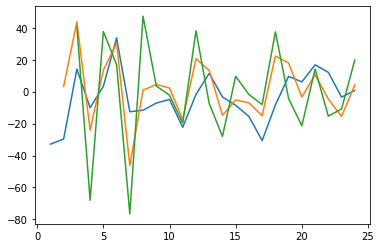

In [20]:
test = pd.read_csv("static/BTC-USD_1d.csv")
del test['Adj Close']
del test['Volume']
test["Date"] = pd.to_datetime(test["Date"])
test = test[:25]
add_performance(df=test, name="perf_%")
add_volatility(df=test, name="volt_%")
add_moving_average(df=test, column="Close", name="ma_close_5", periods=5)

add_first_derivative(df=test, column="Close", name="d1")
add_first_derivative(df=test, column="d1", name="d2")
add_first_derivative(df=test, column="d2", name="d3")
test["d1"].plot()
test["d2"].plot()
test["d3"].plot()
#test["ma"].plot()
test.head(10)